In [26]:
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import stim

False


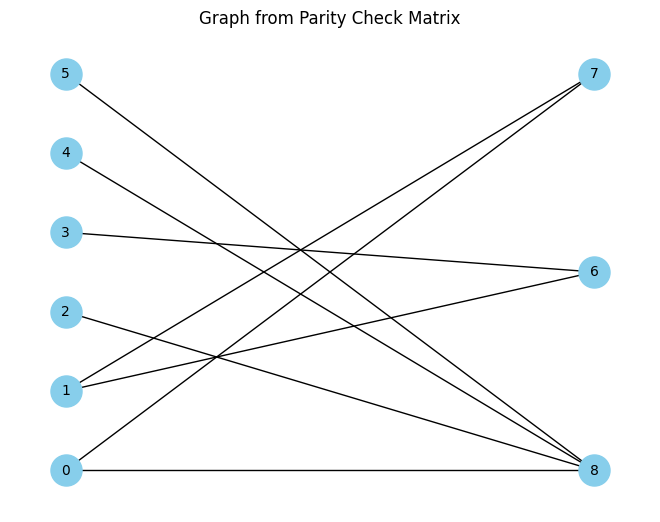

In [14]:
#The following parity check matrix is generated using Radford Neals LDPC-Codes Library
#./make-ldpc dummy 6 12 1 evenboth 3
big_binary_string = """ 1 0 1 1 0 0 1 0 1 0 0 1
                    0 1 1 0 0 1 1 1 0 0 0 1
                    0 1 0 1 1 1 0 0 1 1 0 0
                    1 1 1 0 1 0 0 0 1 0 1 0
                    0 0 0 0 0 1 1 1 0 1 1 1
                    1 0 0 1 1 0 0 1 0 1 1 0"""

binary_string = """ 0 1 0 1 0 0
                    1 1 0 0 0 0
                    1 0 1 0 1 1 """
H = np.array([[int(bit) for bit in line.split()] for line in binary_string.split('\n')])
print(scipy.sparse.issparse(H))

# Create a bipartite graph
G = nx.Graph()

# Determine the dimensions of the parity check matrix
num_checks, num_vars = H.shape

# Create variable nodes and check nodes
variable_nodes = list(range(num_vars))
check_nodes = list(range(num_vars, num_vars + num_checks))

# Add nodes to the graph
G.add_nodes_from(variable_nodes, bipartite=0)  # Variable nodes
G.add_nodes_from(check_nodes, bipartite=1)     # Check nodes

# Add edges between variable and check nodes based on the parity check matrix
for i in range(num_checks):
    for j in range(num_vars):
        if H[i, j] == 1:
            G.add_edge(j, num_vars + i)


pos = nx.bipartite_layout(G, variable_nodes)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black')
plt.title("Graph from Parity Check Matrix")
plt.show()

136
136
272


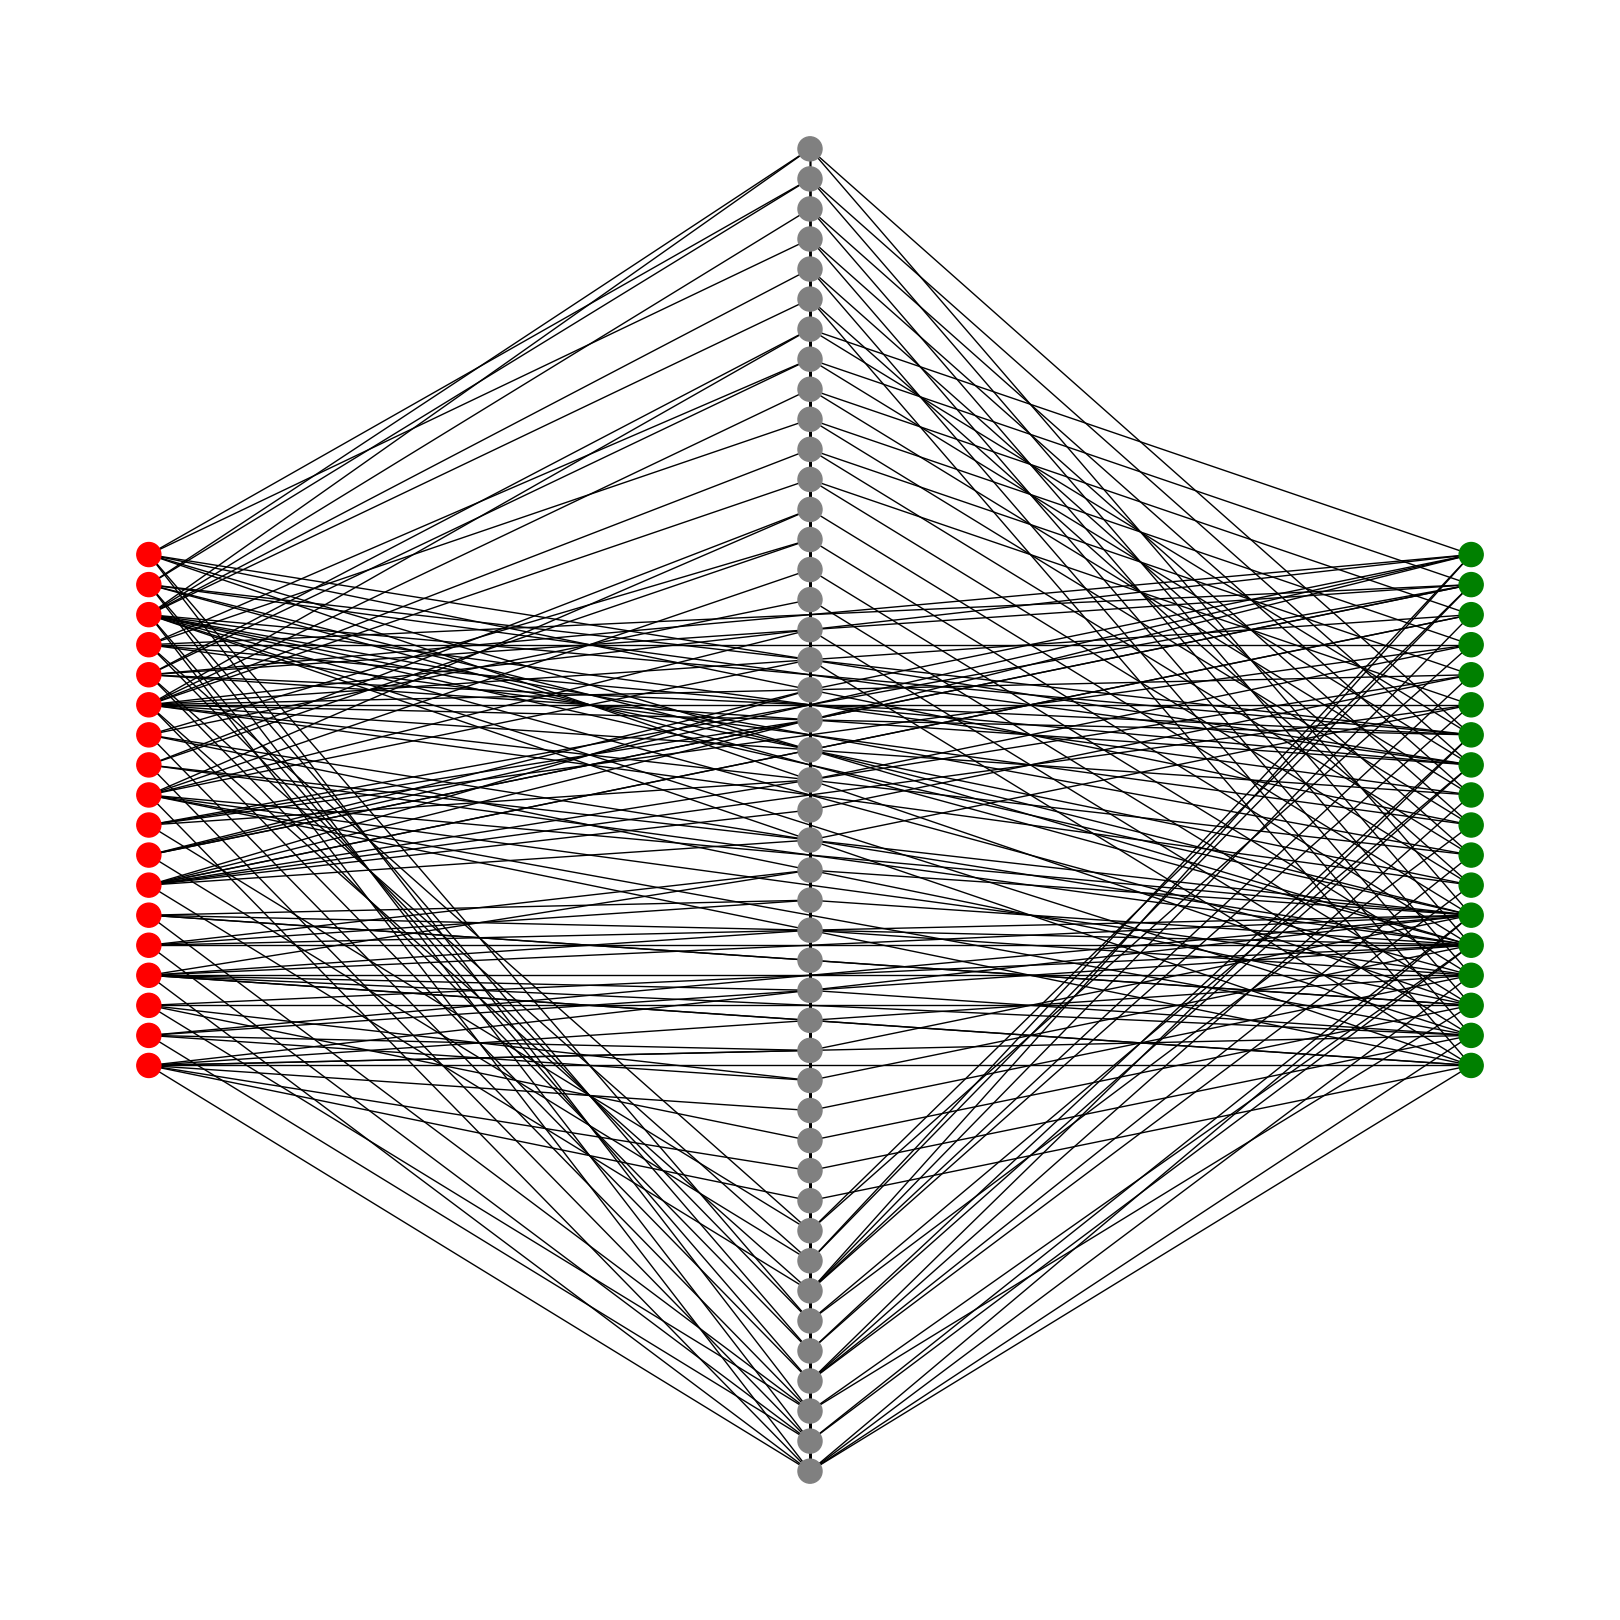

In [15]:
#Code to Construct QLDPC Code From LDPC Code Following Construction given by Tillich and Zemor

#cartesian Product
def cp(a : list[int], b : list[int]):
    res = []
    for i in a:
        for j in b:
            res.append((i,j))
    return res

VxC = cp(variable_nodes,check_nodes)
CxV = cp(check_nodes,variable_nodes) 
VxVuCxC = cp(variable_nodes,variable_nodes) + cp(check_nodes,check_nodes)
Q = nx.strong_product(G,G)
print(len(Q.edges(VxC)))
print(len(Q.edges(CxV)))
print(len(Q.edges))
#Constructing the tripartiteGraph
subset_sizes = [len(VxC) , len(Q.nodes()) - 2*len(VxC), len(CxV)]
subset_color = ["red", "grey", "green"]
HP = nx.Graph()
HP.add_nodes_from(VxC, layer=0)
HP.add_nodes_from(VxVuCxC, layer=1)
HP.add_nodes_from(CxV, layer=2)
HP.add_edges_from(Q.edges)
color = [subset_color[data["layer"]] for v, data in HP.nodes(data=True)]
pos = nx.multipartite_layout(HP, subset_key="layer")
plt.figure(figsize=(16, 16))
nx.draw(HP, pos, node_color=color, with_labels=False)
plt.show()


In [47]:

Qubits = {i:list(HP.nodes)[i] for i in range(len(HP.nodes))}
is_x_check = lambda i : Qubits[i] in VxC
is_z_check = lambda i : Qubits[i] in CxV
is_basic = lambda i : Qubits[i] in VxVuCxC
is_connected = lambda i,j : (Qubits[i],Qubits[j]) in list(HP.edges)
circuit = stim.Circuit()
for i in Qubits:
    if is_basic(i):
        circuit.append("H", [i])
for i in Qubits:
    if is_x_check(i):
        for j in Qubits:
            if is_basic(j) and is_connected(i,j):
                circuit.append("CNOT", [j,i])
for i in Qubits:
    if is_x_check(i):
        circuit.append("MR",i)        
for i in Qubits:
    if is_basic(i):
        circuit.append("H", [i])
for i in Qubits:
    if is_z_check(i):
        for j in Qubits:
            if is_basic(j) and is_connected(j,i):
                circuit.append("CNOT", [j,i])
for i in Qubits:
    if is_z_check(i):
        circuit.append("MR",i)   
    
print(repr(circuit))


stim.Circuit('''
    H 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
    CX 19 0 21 0 57 0 60 0 18 1 19 1 58 1 61 1 18 2 20 2 22 2 23 2 59 2 62 2 25 3 27 3 54 3 57 3 24 4 25 4 55 4 58 4 24 5 26 5 28 5 29 5 56 5 59 5 31 6 33 6 60 6 30 7 31 7 61 7 30 8 32 8 34 8 35 8 62 8 37 9 39 9 54 9 36 10 37 10 55 10 36 11 38 11 40 11 41 11 56 11 43 12 45 12 60 12 42 13 43 13 61 13 42 14 44 14 46 14 47 14 62 14 49 15 51 15 60 15 48 16 49 16 61 16 48 17 50 17 52 17 53 17 62 17
    MR 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
    H 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
    CX 24 63 36 63 55 63 56 63 25 64 37 64 54 64 55 64 26 65 38 65 56 65 27 66 39 66 54 66 28 67 40 67 56 67 29 68 41 68 56 68 18 69 24 69 58 69 59 69 19 70 25 70 57 70 58 70 20 71 26 71 59 71 21 72 27 72 57 72 22 73 28 73 59 73 23 74 29 74 59 74 18 75 

stim.Circuit('''
    H 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
    CX 19 0 21 0 57 0 60 0 18 1 19 1 58 1 61 1 18 2 20 2 22 2 23 2 59 2 62 2 25 3 27 3 54 3 57 3 24 4 25 4 55 4 58 4 24 5 26 5 28 5 29 5 56 5 59 5 31 6 33 6 60 6 30 7 31 7 61 7 30 8 32 8 34 8 35 8 62 8 37 9 39 9 54 9 36 10 37 10 55 10 36 11 38 11 40 11 41 11 56 11 43 12 45 12 60 12 42 13 43 13 61 13 42 14 44 14 46 14 47 14 62 14 49 15 51 15 60 15 48 16 49 16 61 16 48 17 50 17 52 17 53 17 62 17
    H 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
''')


In [34]:
HP.edges

EdgeView([((0, 6), (0, 1)), ((0, 6), (0, 3)), ((0, 6), (7, 6)), ((0, 6), (8, 6)), ((0, 6), (7, 1)), ((0, 6), (7, 3)), ((0, 6), (8, 1)), ((0, 6), (8, 3)), ((0, 7), (0, 0)), ((0, 7), (0, 1)), ((0, 7), (7, 7)), ((0, 7), (8, 7)), ((0, 7), (7, 0)), ((0, 7), (7, 1)), ((0, 7), (8, 0)), ((0, 7), (8, 1)), ((0, 8), (0, 0)), ((0, 8), (0, 2)), ((0, 8), (0, 4)), ((0, 8), (0, 5)), ((0, 8), (7, 8)), ((0, 8), (8, 8)), ((0, 8), (7, 0)), ((0, 8), (7, 2)), ((0, 8), (7, 4)), ((0, 8), (7, 5)), ((0, 8), (8, 0)), ((0, 8), (8, 2)), ((0, 8), (8, 4)), ((0, 8), (8, 5)), ((1, 6), (1, 1)), ((1, 6), (1, 3)), ((1, 6), (6, 6)), ((1, 6), (7, 6)), ((1, 6), (6, 1)), ((1, 6), (6, 3)), ((1, 6), (7, 1)), ((1, 6), (7, 3)), ((1, 7), (1, 0)), ((1, 7), (1, 1)), ((1, 7), (6, 7)), ((1, 7), (7, 7)), ((1, 7), (6, 0)), ((1, 7), (6, 1)), ((1, 7), (7, 0)), ((1, 7), (7, 1)), ((1, 8), (1, 0)), ((1, 8), (1, 2)), ((1, 8), (1, 4)), ((1, 8), (1, 5)), ((1, 8), (6, 8)), ((1, 8), (7, 8)), ((1, 8), (6, 0)), ((1, 8), (6, 2)), ((1, 8), (6, 4)), 